In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

from statsmodels.tsa.stattools import acf, pacf, ccovf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import train_test_split
%matplotlib inline

In [4]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [5]:
from nfn import NFN
from helpers import Dataset

In [50]:
PI = np.pi
TAU = 2 * np.pi

def get_phase(duration, frequency, phase, sampling_rate):
    n = int(duration * sampling_rate)
    w = TAU * frequency / sampling_rate
    return w, (w * np.arange(n) + phase) % TAU

(-40, 440)

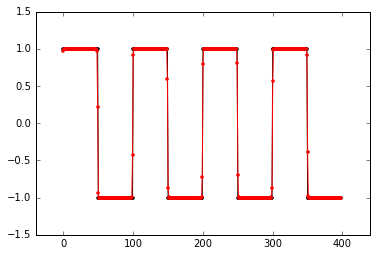

In [53]:
w, t = get_phase(1, 440, 0, 44100)
c = 2.0

k = 400
y = np.sign(np.sin(t[1:k]))
z = np.tanh(c / w * np.sin(t[1:k]))
plt.plot(y, 'k.-')
plt.plot(z, 'r.-')
plt.ylim(-1.5, 1.5)
plt.xlim(-k // 10, k + k // 10)

In [ ]:
data = pd.read_csv('data.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
weather = pd.read_csv('weather.csv')
weather.replace({'Precipitat': {'T': 0}}, inplace=True)
data['precipitation'] = np.repeat(weather.Precipitat.values.astype(float), 96, axis=0)[20:20+data.shape[0]]
data['temperature'] = np.repeat(weather.Temperat.values.astype(float), 96, axis=0)[20:20+data.shape[0]]

In [ ]:
g = data.groupby('day_id')['gh'].mean().values
u = data.groupby('day_id')['precipitation'].mean().values
t = data.groupby('day_id')['temperature'].mean().values

#y = data.gh.values
#u = data.precipitation.values
#t = data.temperature.values

In [ ]:
DG = Dataset(g, range(1,11))
DU = Dataset(u, range(1,3))
DT = Dataset(t, range(1,5))

In [ ]:
X, y, x_ranges = DG.get_scaled()
U, _, u_ranges = DU.get_scaled()
T, _, t_ranges = DT.get_scaled()
k = np.min([X.shape[0], U.shape[0], T.shape[0]])

X = np.hstack([X[-k:], U[-k:], T[-k:]])
ranges = np.vstack([x_ranges, u_ranges, t_ranges])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
y = np.array(data.gh.values)
"""for i in range(y.size - 1000):
    p = np.random.rand()
    if p < 0.0005:
        b = 2*np.round(np.random.rand()) - 1
        y[i] += b * (2 + np.random.rand())
        k = 1
        while np.random.rand() < 0.99:
            y[i+k] += b *(1 + 0.3*np.random.randn())
            k += 1"""

In [ ]:
k = 128
m = k // 2 + 1
n = y.size // k

spectrogram = np.zeros((n, m))
for i in range(n):
    spectrogram[i] = np.abs(np.fft.rfft(y[k*i:k*(i+1)])[::-1])
    
avg_spectrum = spectrogram.mean(axis=1)
energy = np.square(spectrogram).sum(axis=1) / np.square(avg_spectrum).sum()
    
j = 128
plt.figure(figsize=(16,4))
plt.plot(y[:j*k])
plt.xlim(0,j*k)

plt.figure(figsize=(16,4))
plt.imshow(np.log(1 + spectrogram.T[:,:j]), aspect='auto', interpolation='nearest')

plt.figure(figsize=(16,4))
plt.plot(energy[:j])
plt.xlim(0,j)

In [ ]:
plt.semilogy(1 + spectrogram[78])
plt.grid(which='both')

In [ ]:
X = np.vstack([g, u, t]).T

var = VAR(X)
var_res = var.fit(maxlags=15, ic='aic', trend='c')

plt.plot(X[15:,0])
plt.plot(var_res.fittedvalues[:,0])
plt.xlim(0,300)

In [ ]:
r2_score(X[15:,0], var_res.fittedvalues[:,0])

In [ ]:
X.shape, ranges.shape

In [ ]:
nfn = NFN(16, 32, ranges, init_X=X, init_y=y)

In [ ]:
i, best, train_error, test_error, steps = nfn.train(X, y, X_test, y_test, 
                                                    n_epochs=10000, max_no_best=32, tol=1e-7, is_adaptive=True,
                                                    verbose=100, return_errors=True, return_steps=True)

In [ ]:
r2_score(y, y_pred)

In [ ]:
y_out = g.copy()
y_out[500:600]   -= 0.02*np.arange(100)
y_out[1000:1200] += 0.01*np.arange(200)
y_out[1500:1800] += 0.01*np.arange(300)
DO = Dataset(y_out, range(1,11))
X, y_out, x_ranges = DO.get_scaled()

k = np.min([X.shape[0], U.shape[0], T.shape[0]])

X = np.hstack([X[-k:], U[-k:], T[-k:]])
ranges = np.vstack([x_ranges, u_ranges, t_ranges])

In [ ]:
plt.plot(nfn._W[:,10])
plt.plot(nfn._W[:,11])

In [ ]:
plt.hist(u[u>0], bins=100);

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(g[1:] - g[:-1])
plt.plot(0.05*u - 4)
plt.xlim(0,500)

In [ ]:
plt.figure(figsize=(16,4))
e = y_out - y_pred
plt.plot(e)

In [ ]:
plt.imshow(nfn._W, interpolation='nearest')

In [ ]:
plt.plot(nfn._W[:,9])
plt.plot(nfn._W[:,8])
plt.plot(nfn._W[:,7])
plt.plot(nfn._W[:,10])

In [ ]:
def wiener_process(n, mu=0.0, sigma=1.0):
    y = np.zeros(n)
    for i in range(1,n):
        y[i] = mu + y[i-1] + sigma*np.random.randn()
    return y


def ARMAX_sim(ar_params=list(), 
              ma_params=list(), 
              ex_params=list(), 
              c=0, 
              u=np.zeros(1), 
              init=None, 
              n=100, 
              sigma=1.0):
    
    p = len(ar_params)
    q = len(ma_params)
    r = len(ex_params)
    k = np.max(p, q, r)
    
    if init is None:
        y = np.zeros(n)
        y[:k] = np.random.randn(k)
    elif len(init) == k:
        y = np.zeros(n)
        y[:k] = init
    else:
        raise Exception('Bad initials')
        
    e = sigma*np.random.randn(n)
    for i in range(k, n):
        y[i] = c + np.dot(ar_params, y[i-p:i]) + np.dot(ma_params, e[i-q:i]) + np.dot(ex_params, u[i-r:i]) + e[i]
    return y

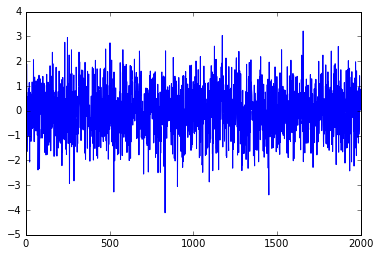

In [5]:
n = 2000
y = np.random.randn(n) #ARMAX_sim([0.8, 0.1], n=1000, sigma=0.1)
plt.plot(y)

In [6]:
X = np.zeros((n-1,n-1))
for i in range(n-1):
    X[i,:i+1] = y[:i+1][::-1]

In [7]:
p, r, R, S = np.linalg.lstsq(X, y[1:])

In [8]:
y_pred = np.dot(X, p)

In [9]:
np.square(y[1:] - y_pred).mean(), np.square(y[1:] - y[:-1]).mean()

(0.017468842198428286, 1.86657151124125)

In [10]:
from sklearn.metrics import r2_score

r2_score(y_pred, y[1:])

0.98187107816885288

(0, 200)

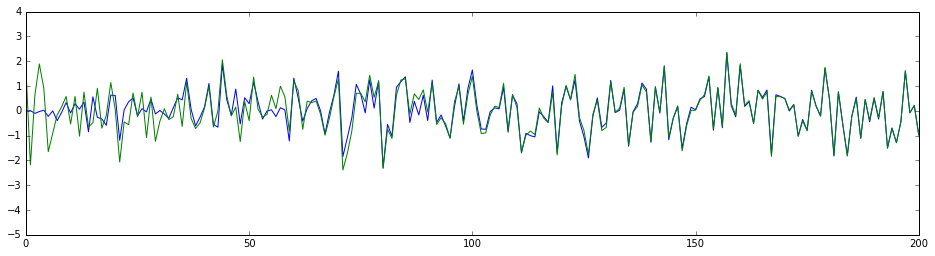

In [11]:
plt.figure(figsize=(16,4))
plt.plot(y_pred)
plt.plot(y[1:])
plt.xlim(0,200)

In [ ]:
plt.plot(y_pred - y[1:])

In [ ]:
n = 1000
q = 3
p = 3

# y = ARMA_simulation(np.array([0.6, -0.4, 0.3]), 1, n = n, sigma=0.5) 
# y = np.random.randn(n) + 0.005*np.arange(n) 
# y = wiener_process(n)
y = ARMA_simulation([0.45, 0.3, -0.2], [0.1, -0.2, 0.05], init=[4, 4, 4], n = n, sigma=0.1)
z = np.zeros(:max(p,q))

a = 0.01*np.random.randn(p)
b = 0.01*np.random.randn(q)
c = 0

e = 0
cache_a = np.zeros(p)
cache_b = np.zeros(q)
cache_c = 0
alpha = 0.98

In [ ]:
arma = ARMA(y, (3, 3))
arma_res = arma.fit(maxiter=1000)
arma_res.arparams, arma_res.maparams

In [ ]:
e = np.mean(e) + np.zeros(n)
e_max = 100
step = 0.05

for i in range(max(p,q),n):
    z[i] = np.dot(a, y[i-p:i]) + np.dot(b, e[i-q:i]) + c
    e[i] = z[i] - y[i]
    
    cache_a = alpha*cache_a + (1 - alpha)*np.square(y[i-p:i]*e[i])
    cache_b = alpha*cache_b + (1 - alpha)*np.square(e[i-q:i]*e[i])
    cache_c = alpha*cache_c + (1 - alpha)*np.square(e[i])    
    
    a -= (step / (1 + np.sqrt(cache_a))) * y[i-p:i]*e[i]
    b -= (step / (1 + np.sqrt(cache_b))) * e[i-q:i]*e[i]
    c -= (step / (1 + np.sqrt(cache_c))) * e[i]

z = np.zeros(n)
for i in range(max(p,q),n):
    z[i] = np.dot(a, y[i-p:i]) + np.dot(b, e[i-q:i]) 

print(cache_a, cache_b, cache_c)
print(a, b, c)
print(mean_squared_error(y, z))
print(r2_score(y, z))

plt.figure(figsize=(16,3))
plt.plot(y)
plt.plot(z)

In [ ]:
z = np.zeros(n)
for i in range(max(p,q),n):
    z[i] = np.dot(a, y[i-p:i])

plt.figure(figsize=(16,3))
plt.plot(y)
plt.plot(z)
plt.xlim(0,200)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
plt.plot(acf(y))

In [ ]:
a, b

In [ ]:
plt.figure(figsize=(16,3))
plt.plot()

In [ ]:
z = ARMA_simulation(0.5*np.random.randn(2), np.random.rand(5), n=1000, sigma=0.1)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(z)
plt.xlim(0,100)

In [ ]:
y = 2.5*np.sin(0.0172*t + 50)

Z = np.zeros((100, 100))
i = 0
for w in np.linspace(0.01, 0.025, 100):
    for f in range(100):
        z = 2.5*np.sin(w*t + f)
        Z[i,f] = mean_squared_error(y, z)
    i += 1

In [ ]:
best_score = 1e+27
best_phi = 0

omega = 2 * np.pi / 365.25

for omega in range(1,730):
    

for phi in range(365):
    X = np.vstack([np.ones(t.size), t, np.sin(omega*t + phi)]).T
    theta = np.linalg.lstsq(X, g)[0]
    y = theta[0] + theta[1]*t + theta[2]*np.sin(omega*t + phi)
    r = mean_squared_error(g, y)
    if r < best_score:
        best_score = r
        best_phi = phi

omega = 2 * np.pi / 365.25
phi = best_phi
X = np.vstack([np.ones(t.size), t, np.sin(omega*t + phi)]).T
theta = np.linalg.lstsq(X, g)[0]

In [ ]:
def periodicity(y):
    cf = acf(y, unbiased=True, nlags=g.size // 2)
    idx = list()
    for i in range(1,cf.size):
        if cf[i] * cf[i-1] < 0:
            idx.append(i)
    T = [idx[i] - idx[i-2] for i in range(2,len(idx))]
    return np.mean(T)

In [ ]:
plt.figure(figsize=(16,4))
for k in range(20):
    r = np.zeros(401)
    r[191:210] = 1 / 19
    p = r.copy()
    for i in range(k):
        p = np.convolve(p,r, mode='same')
    plt.plot(p)

In [ ]:
from scipy import signal
import pywt

In [ ]:
cA, cD = pywt.dwt(t, wavelet='haar')

In [ ]:
plt.plot(cA)

In [ ]:
n = 6000
z = np.zeros(n)
for i in range(1,n):
    z[i] = z[i-1] + np.random.randn()

k_max = 500
cwmat = np.zeros((k_max,z.size))
for k in range(1,k_max+1):
    kernel = np.ones(2*k)
    kernel[k:] = -1
    kernel /= np.sqrt(kernel.size)
    cwmat[k-1] = np.convolve(z, kernel, mode='same')
    
plt.figure(figsize=(16,4))
plt.imshow(cwmat, aspect='auto', interpolation='nearest')

In [ ]:
plt.plot(z)

In [ ]:
n = 6000
z = np.zeros(n)
for i in range(1,n):
    z[i] = z[i-1] + np.random.randn()

In [ ]:
widths = np.arange(1, 256)
cwtmatr = signal.cwt(t, signal.ricker, widths)
plt.figure(figsize=(16,4))
plt.imshow(cwtmatr, aspect='auto') #, vmax = abs(cwtmatr).max(), vmin = -abs(cwtmatr).max())


In [ ]:
plt.figure(figsize=(16,4))
plt.plot(g)
plt.xlim(0,g.size)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(cwmat[6])
plt.xlim(0,g.size)